In [1]:
from __future__ import print_function
%matplotlib inline

### Index
[Import data](#1)   
[0. Generate datasets](#6)  
[1. k-fold cross-validation on posts](#7)  
[2. Train size: random set of posts](#8)  
[3. Leave one page out](#10)  
[4. Leave half pages out](#11)  

### <a id='1'></a> Import data

In [2]:
import json
import numpy as np
import pandas as pd

In [3]:
with open('likers.json') as data_file:
    data = json.load(data_file)

print('Json length: %s' % len(data))

Json length: 15500


In [4]:
hoax_pages = {'188189217954979',
              '253520844711659',
              '199277020680',
              '233426770069342',
              '68091825232',
              '194120424046954',
              '126393880733870',
              '109383485816534',
              '203737476337348',
              '159590407439801',
              '124489267724876',
              '123944574364433',
              '130541730433071',
              '278440415537619',
              '101748583911',
              '352513104826417',
              '195235103879949'}

### <a id='6'></a> 0. Generate datasets

In [5]:
%%time
import df_utils

print('Full dataset:')
like_matrix, page, hoax = df_utils.cut_dataset(data,
                                                hoax_pages,
                                                min_post_like=0,
                                                min_user_like=0,
                                                print_results=True)
print('\nIntersection dataset:')
like_matrix_i, page_i, hoax_i = df_utils.filter_intersection(data,
                                                hoax_pages,
                                                print_results=True)
print()

Full dataset:
Posts with 0+ likes = 15500 (8923 hoax)
Users with 0+ likes = 909236
2376776 non-zero values out of 14093158000 (loading factor: 0.00%)

Intersection dataset:
Total users: 909236, Intersection users: 14139
117641 non-zero values out of 148742280 (loading factor: 0.00%)

CPU times: user 30.3 s, sys: 1.02 s, total: 31.3 s
Wall time: 33.2 s


### <a id='7'></a> 1. k-fold cross-validation on posts

In [6]:
%%time
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def test_1(like_matrix, hoax):
    logreg = linear_model.LogisticRegression(C=1)
    return cross_val_score(logreg, like_matrix, hoax, cv=5)

score_test_1 = test_1(like_matrix, hoax)
print('Full dataset - mean: %.3f, std: %.3f' % (np.mean(score_test_1), np.std(score_test_1)))
score_test_1_i = test_1(like_matrix_i, hoax_i)
print('Intersection dataset - mean: %.3f, std: %.3f\n' % (np.mean(score_test_1_i), np.std(score_test_1_i)))

Full dataset - mean: 0.986, std: 0.002
Intersection dataset - mean: 0.955, std: 0.006

CPU times: user 46.1 s, sys: 908 ms, total: 47 s
Wall time: 47.8 s


### <a id='8'></a> 2. Train size: random set of posts

In [7]:
%%time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

def test_2(like_matrix, hoax, test_size, iterations=50):
    accuracy_list = []
    for seed in range(iterations):
        X_train, X_test, Y_train, Y_test = train_test_split(like_matrix, hoax, test_size=test_size, random_state=seed)
        logreg = linear_model.LogisticRegression(C=1)
        logreg.fit(X_train, Y_train)
        Y_pred = logreg.predict(X_test)
        accuracy_list.append(metrics.accuracy_score(Y_test, Y_pred))
    return accuracy_list

score_test_2 = test_2(like_matrix, hoax, 0.9)
print('Full dataset - mean: %.2f, std: %.2f' % (np.mean(score_test_2), np.std(score_test_2)))
score_test_2_i = test_2(like_matrix_i, hoax_i, 0.9)
print('Intersection dataset - mean: %.2f, std: %.2f' % (np.mean(score_test_2_i), np.std(score_test_2_i)))
print()

Full dataset - mean: 0.97, std: 0.01
Intersection dataset - mean: 0.92, std: 0.01

CPU times: user 4min 46s, sys: 6.43 s, total: 4min 52s
Wall time: 5min 4s


In [8]:
%%time
res_all_x = [10, 20, 50, 100, 200, 400, 1000]
score_test_2 = [test_2(like_matrix, hoax, 1-(1/float(i))) for i in res_all_x]
score_test_2_i = [test_2(like_matrix_i, hoax_i, 1-(1/float(i))) for i in res_all_x]
print('Done\n')

Done

CPU times: user 24min 1s, sys: 27.9 s, total: 24min 29s
Wall time: 26min 13s


In [9]:
#Graph points
res_all_y = [np.mean(i) for i in score_test_2]
print('res_all_y = %s' % str(res_all_y))
res_all_err = [np.std(i) for i in score_test_2]
print('res_all_err = %s' % str(res_all_err))
res_int_x = [10, 20, 50, 100, 200, 400, 1000]
res_int_y = [np.mean(i) for i in score_test_2_i]
print('res_int_y = %s' % str(res_int_y))
res_int_err = [np.std(i) for i in score_test_2_i]
print('res_int_err = %s' % str(res_int_err))

res_all_y = [0.96669677419354827, 0.95533989813242781, 0.93099144173798531, 0.90329749103942636, 0.84348699993516163, 0.74553227266847766, 0.63488149822408779]
res_all_err = [0.0055568473928726322, 0.0096648261910718368, 0.019235373404428768, 0.038534806597708672, 0.059711620024988706, 0.086215312070645644, 0.11551090232666143]
res_int_y = [0.91654203633291076, 0.89193315989593758, 0.84144907856450035, 0.77512049927988469, 0.70986052732136029, 0.63810367829235748, 0.56102949571836336]
res_int_err = [0.0077756103084875598, 0.013865324498876704, 0.029058334540871818, 0.047490066556372029, 0.05720552897645028, 0.060875349450386827, 0.054692571945068366]


[]

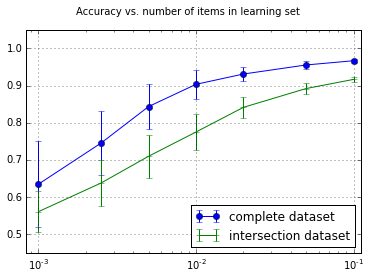

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
res_a_x = [1.0 / x for x in res_all_x]
res_i_x = [1.0 / x for x in res_int_x]
fig, ax = plt.subplots(1)
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='complete dataset')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='+', label='intersection dataset')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend(loc='lower right')
ax.grid()
fig.suptitle('Accuracy vs. number of items in learning set')
plt.plot()

### <a id='10'></a> 3. Leave one page out

In [11]:
%%time
from sklearn import linear_model
from sklearn import metrics
import df_utils

def test_3(like_matrix, hoax, page):
    accuracy_list = []
    for p in set(page):
        matrix_test, hoax_test, matrix_train, hoax_train = df_utils.split_pages(like_matrix, page, hoax, [str(p)])
        logreg = linear_model.LogisticRegression(C=1)
        logreg.fit(matrix_train, hoax_train)
        Y_pred = logreg.predict(matrix_test)
        acc = metrics.accuracy_score(hoax_test, Y_pred)
        accuracy_list.append(acc)
    return accuracy_list

score_test_3 = test_3(like_matrix, hoax, page)
print('Full dataset - mean: %.3f, std: %.3f' % (np.mean(score_test_3), np.std(score_test_3)))
score_test_3_i = test_3(like_matrix_i, hoax_i, page_i)
print('Intersection dataset - mean: %.3f, std: %.3f\n' % (np.mean(score_test_3_i), np.std(score_test_3_i)))

Full dataset - mean: 0.794, std: 0.303
Intersection dataset - mean: 0.655, std: 0.292

CPU times: user 8min 10s, sys: 6.87 s, total: 8min 17s
Wall time: 8min 25s


### <a id='11'></a> 4. Leave half pages out

In [12]:
from sklearn import linear_model
from sklearn import metrics
import df_utils
import random

pages_list = set(page)
hoax_pages = [p for p in pages_list if p in hoax_pages] #remove pages with no posts
not_hoax_pages = [p for p in pages_list if p not in hoax_pages]

accuracy_list = []
for seed in range(50):
    random.seed(seed)
    pages_tosplit = random.sample(hoax_pages, int(len(hoax_pages)/2.))
    pages_tosplit.extend(random.sample(not_hoax_pages, int(len(not_hoax_pages)/2.)))
    matrix_train, hoax_train, matrix_test, hoax_test = df_utils.split_pages(like_matrix, page, hoax, pages_tosplit)
    logreg = linear_model.LogisticRegression(C=1)
    logreg.fit(matrix_train, hoax_train)
    Y_pred = logreg.predict(matrix_test)
    acc = metrics.accuracy_score(hoax_test, Y_pred)
    accuracy_list.append(acc)
print('Full dataset - mean: %.3f, std: %.3f\n' % (np.mean(accuracy_list), np.std(accuracy_list)))

Full dataset - mean: 0.716, std: 0.143



In [13]:
from sklearn import linear_model
from sklearn import metrics
import df_utils
import random

pages_list = set(page_i)
hoax_pages = [p for p in pages_list if p in hoax_pages] #remove pages with no posts
not_hoax_pages = [p for p in pages_list if p not in hoax_pages]

accuracy_list_i = []
for seed in range(50):
    random.seed(seed)
    pages_tosplit = random.sample(hoax_pages, int(len(hoax_pages)/2.))
    pages_tosplit.extend(random.sample(not_hoax_pages, int(len(not_hoax_pages)/2.)))
    matrix_train, hoax_train, matrix_test, hoax_test = df_utils.split_pages(like_matrix_i, page_i, hoax_i, pages_tosplit)
    logreg = linear_model.LogisticRegression(C=1)
    logreg.fit(matrix_train, hoax_train)
    Y_pred = logreg.predict(matrix_test)
    acc = metrics.accuracy_score(hoax_test, Y_pred)
    accuracy_list_i.append(acc)
print('Intersection dataset - mean: %.3f, std: %.3f\n' % (np.mean(accuracy_list_i), np.std(accuracy_list_i)))

Intersection dataset - mean: 0.587, std: 0.112

